# Part 1: Load data

Let's load some useful Python libraries:
1. numpy: structural data types
2. pandas: data loading and manipulation
3. matplotlib, sns: data visualization
4. sklearn: data analytics algorithms

In [2]:
#%% load library
import gc
#import resource
import rope
#import operator
import numpy as np
import pandas as pd

In [82]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

We have data from 4 machine fleets. Here we examine the first one FD001.

In [25]:
#%% Load data
print('Start loading data ...')

# Load and combine training data
train_1 = pd.read_csv('./input/train_FD001.txt', delim_whitespace=True, header=None)
#train_2 = pd.read_csv('./input/train_FD002.txt', delim_whitespace=True, header=None)
#train_3 = pd.read_csv('./input/train_FD003.txt', delim_whitespace=True, header=None)
#train_4 = pd.read_csv('./input/train_FD004.txt', delim_whitespace=True, header=None)

train = train_1

Start loading data ...


In [26]:
# Check dimension
print('Dimension of train_FD001: ', train.shape)

Dimension of train_FD001:  (20631, 26)


In [27]:
# Assign column headers: id, te, (time evolutions) os1, os2, os3, (operational settings) s1, s2, ..., s21 (sensors)
sensor_name = ['s'+ str(i) for i in range(1,22)]
train.columns = ['id', 'te', 'os1', 'os2', 'os3'] + sensor_name

### Question 1 (easy):
We have training and testing data from 4 machine fleets (one fleet is one group of machines), FD001 - FD004. From your opinion, which scenarios should we build a model for all machine fleet, or build individual models for each fleet?

# Part 2: Signal Smoothing

Number of cycles per machine:  100


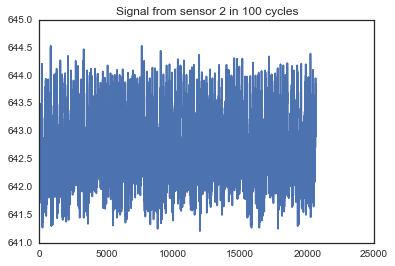

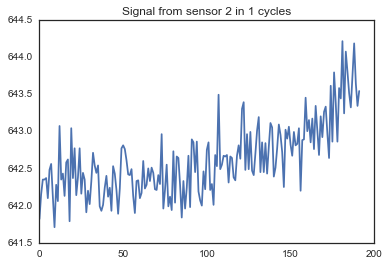

In [28]:
print('Number of cycles per machine: ', train['id'].unique().size)
s2_100_cycle = train.ix[:,'s2']
s2_1_cycle = train.ix[train['id']==1,'s2']
plt.figure(1)
plt.plot(s2_100_cycle)
plt.title('Signal from sensor 2 in 100 cycles')
plt.figure(2)
plt.plot(s2_1_cycle)
plt.title('Signal from sensor 2 in 1 cycles')

As you can see, there is some white noise in the signal. Unless there is useful information on structural noise, such as the noise grows bigger near the failure, we should clean the signal.

[      nan       nan       nan       nan       nan  642.224   642.2425
  642.274   642.31    642.313   642.3175  642.324   642.332   642.3185
  642.3685  642.4395  642.4795  642.4685  642.4235  642.442   642.4605
  642.455   642.4345  642.427   642.391   642.3315  642.292   642.2985
  642.335   642.3265  642.329   642.3255  642.282   642.266   642.273
  642.294   642.3025  642.2685  642.2145  642.1885  642.1875  642.193
  642.202   642.211   642.2485  642.2955  642.348   642.3985  642.4415
  642.46    642.457   642.456   642.4525  642.458   642.4415  642.3845
  642.3195  642.2895  642.2795  642.2635  642.2575  642.268   642.3085
  642.3445  642.344   642.3435  642.361   642.3575  642.3785  642.399
  642.3685  642.365   642.35    642.308   642.278   642.29    642.2975
  642.2975  642.3     642.3     642.2975  642.268   642.2555  642.26
  642.3025  642.3015  642.3065  642.3585  642.3585  642.378   642.4245
  642.429   642.418   642.431   642.4195  642.4355  642.472   642.438
  642.398   

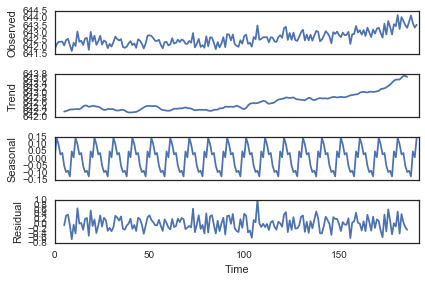

In [9]:
# Smoothing technique: lowpass
"""
from scipy import fftpack

# plot FFT graph
sample_freq = fftpack.fftfreq(sig.size, d=1)
sig_fft = fftpack.fft(s2_1_cycle)
pidxs = np.where(sample_freq > 0)
freqs = sample_freq[pidxs]
power = np.abs(sig_fft)[pidxs]
plt.figure(1)
plt.plot(power)
print(power.size)

# calculate 1st frequency mode and filter other high frequency noise
freq = freqs[power.argmax()]
sig_fft[np.abs(sample_freq) > freq*10] = 0

plt.figure(2)
plt.plot(s2_1_cycle)
plt.figure(3)
s2_1_cycle_smooth = fftpack.ifft(sig_fft)
plt.plot(s2_1_cycle_smooth)
"""

# Smooth technique: decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(s2_1_cycle.values, freq=10)
print(res.trend)
resplot = res.plot()


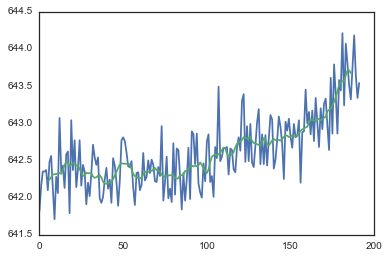

In [10]:
# access individual series by
trend = res.trend
seasonal = res.seasonal
residual = res.resid

plt.plot(s2_1_cycle)
plt.plot(trend)

### Question 2 (easy): 
We should smooth out the sensor signals to remove measurement noises. Should we do that for operational settings too?

Great! We have a method to clean white noise. Now it's time to apply to all the signals (columns in the data frame).

In [29]:
# Apply decomposition for all columns at EACH cycle id.
train = train_1

def f(col):
    smooth_col = seasonal_decompose(col.values, freq=10).trend
    return smooth_col
transformed = train.drop(['te', 'os1', 'os2', 'os3'], axis=1).groupby('id').transform(f)
transformed['id'] = train['id']  # add back because transform will throw away 'id'

# overwrite smooth signals back to train Dataframe
df_1 = train[['id', 'te', 'os1', 'os2', 'os3']]
df_2 = transformed.groupby('id').ffill().bfill().drop('id', axis=1)
train = pd.concat([df_1, df_2], axis=1)

# Part 3: Create target - Remaining Useful Life (RUL)
As discussed in the paper "*Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation*
Abhinav Saxena, Kai Goebel,
Don Simon, Neil Eklund" on how they generated the data, the health index of a machine decelerates exponentially near the failure in terms of time. 

From the time evolution, we need to construct a target signal for our model to predict. We have two options: 
1. Remaining time, which decreases linearly. 
2. Decelerating health index, which decreases exponentially.

### Question 3 (difficult):
Could you give a short discussion on the advantage and disadvantage of each?

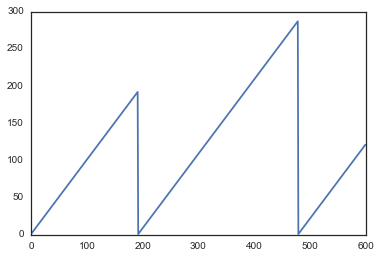

In [31]:
# Plot out the time evolution
plt.plot(train['te'][1:600])

## Option 1 - Linear target

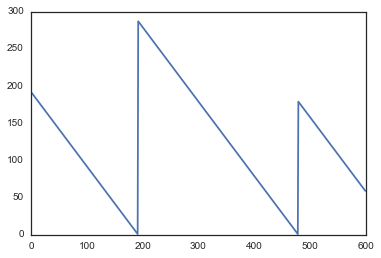

In [32]:
def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1]  

train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

# Part 4: Investigate degenerating sensors

In [67]:
# prepare the data
# then split them into train and test sets
y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = pd.DataFrame(normalize(train[features], axis=0))
X.columns = features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

Optimal value:  3.27644567591e-06
[  2.11804564e+01   1.41434740e+02  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -1.80917143e+05  -2.84266336e+05  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -5.67549067e+05
   0.00000000e+00  -4.22587771e+05   0.00000000e+00   0.00000000e+00
  -1.06273977e+05  -1.66574068e+05   0.00000000e+00  -1.70782630e+04
  -0.00000000e+00  -0.00000000e+00   1.79642919e+05   3.38997157e+05]
Useful sensors to predict RUL:  Index(['os1', 'os2', 's3', 's4', 's9', 's11', 's14', 's15', 's17', 's20',
       's21'],
      dtype='object')


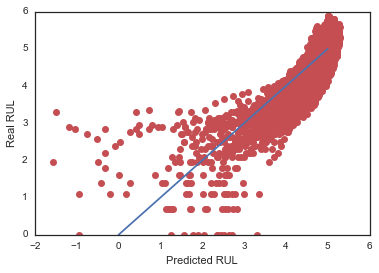

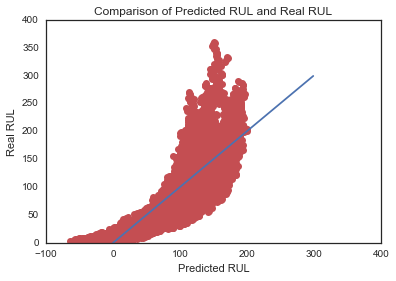

In [68]:
# try Lasso
ls = LassoCV(random_state=12)
ls = ls.fit(X_train, y_train)

#print('List of tried parameter values: ', ls.alphas_)
print('Optimal value: ', ls.alpha_)
print(ls.coef_)
print('Useful sensors to predict RUL: ', X_train.columns[abs(ls.coef_) > 1e-6])

# compare predict RUL and real RUL
plt.figure(1)
plt.plot(np.log(ls.predict(X_test)), np.log(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(ls.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.axis([-100, 400, 0, 400])
plt.plot(range(300), range(300))  # plot the line y = x of perfect prediction


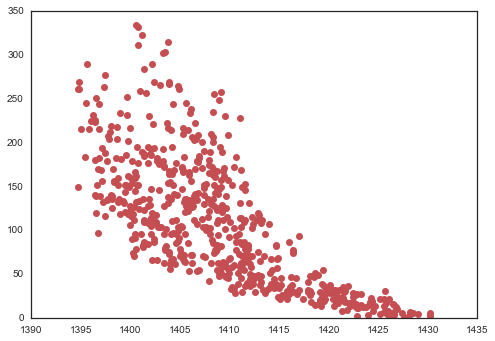

In [101]:
# try plotting signals to convince yourself that these important sensors really have correlation with our target
plt.plot(X_train['s4'][1:600], y_train[1:600], 'ro')

## Option 2 - Exponential target

Optimal value:  0.00975280076258
[ 0.          0.          0.          0.         -0.         -0.04008465
 -0.06005507  0.          0.          0.02878443 -0.         -0.011902    0.
 -0.          0.         -0.          0.00314782 -0.          0.
 -0.02156106  0.          0.          0.          0.        ]
Useful sensors to predict RUL:  Index(['s3', 's4', 's7', 's9', 's14', 's17'], dtype='object')


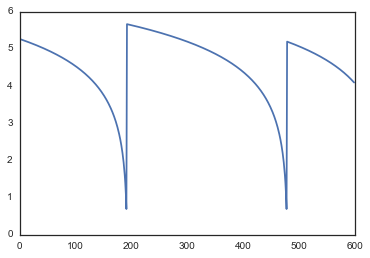

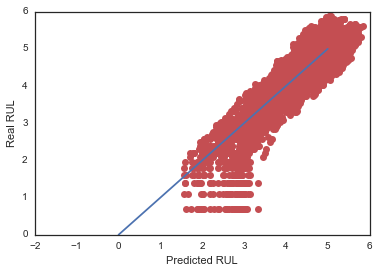

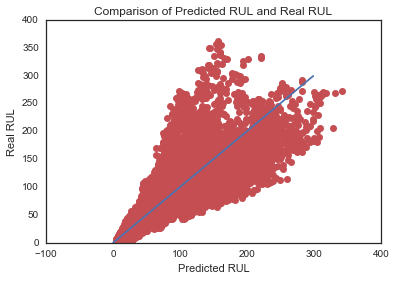

In [378]:
# Now let's try do log transformation to create exponential-degenerating RUL

def f1(col):
    # Option 2: transform time evolution into exponential-degenerating remaining health index 
    return np.log(col[::-1] + 1)  

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Lasso
from sklearn.linear_model import LassoCV

ls = LassoCV(random_state=12)
ls = ls.fit(X_train, y_train)

#print('List of tried parameter values: ', ls.alphas_)
print('Optimal value: ', ls.alpha_)
print(ls.coef_)
print('Useful sensors to predict RUL: ', X_train.columns[abs(ls.coef_) > 1e-6])

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(ls.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))
plt.axis([-2, 6, 0, 6])

plt.figure(3)
plt.plot(np.exp(ls.predict(X_test)), np.exp(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.axis([-100, 400, 0, 400])
plt.plot(range(300), range(300))

# Part 5: Trees

## Option 1 - Linear target

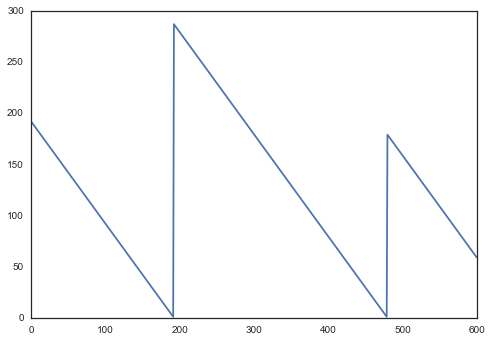

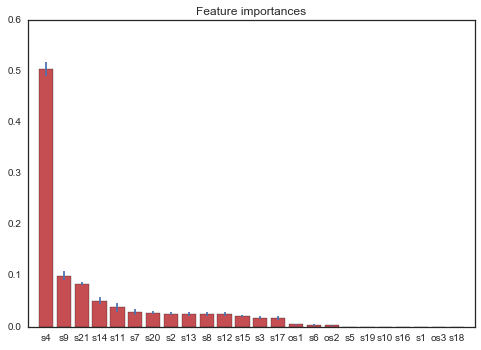

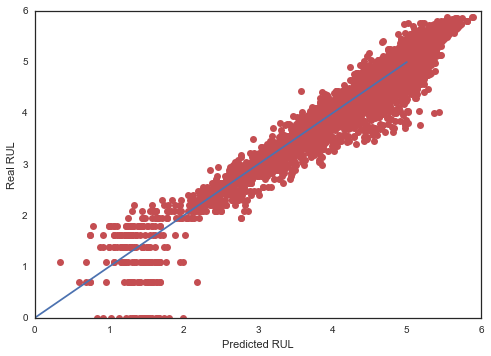

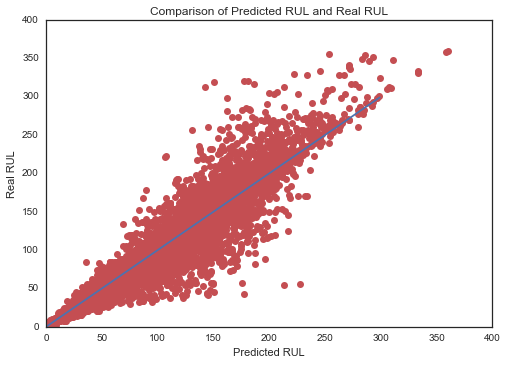

In [100]:
def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1] 

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Random Forest
rf = RandomForestRegressor(random_state=12)
rf = rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()


# compare predict RUL and real RUL
plt.figure(2)
plt.plot(np.log(rf.predict(X_test)), np.log(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))

plt.figure(3)
plt.plot(rf.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.plot(range(300), range(300))

## Option 2 - Exponential target

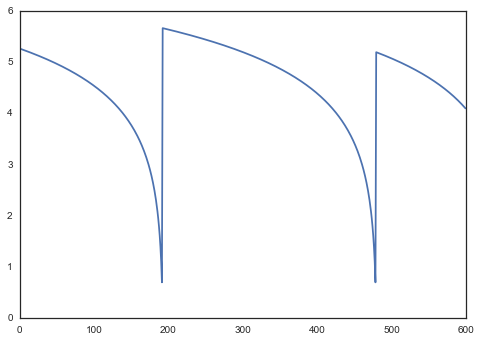

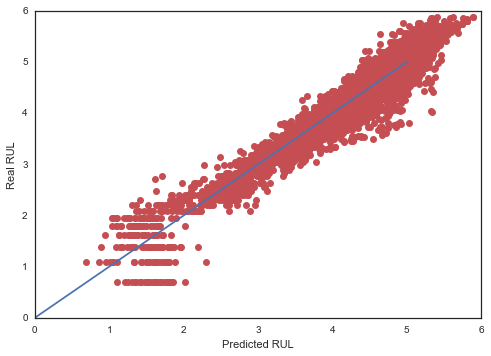

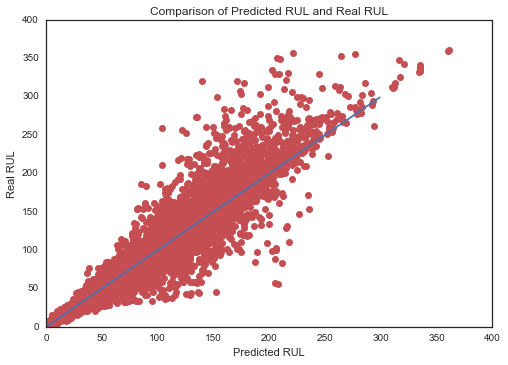

In [103]:
# Now let's try do log transformation to create exponential-degenerating RUL

def f1(col):
    # Option 2: transform time evolution into exponential-degenerating remaining health index 
    return np.log(col[::-1] + 1)  

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Lasso
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=12)
rf = rf.fit(X_train, y_train)

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(rf.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))
#plt.axis([-2, 6, 0, 6])

plt.figure(3)
plt.plot(np.exp(rf.predict(X_test)), np.exp(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.plot(range(300), range(300))

#### REMARK
It is clear that Random Forest doesn't care about the transformation, as long as the transformation function is monotonically increase (x >= y equivalent to f(x) >= f(y), in this case f(x) = log(x)).

Furthermore, our raw, un-tuned nonlinear model Random Forest beats the CV_tuned optimal linear Lasso.

### Grand Question:
Run the experiment again for the machine fleet FD003 and observe the result. Note that FD003 is more complicated than FD001 because while FD001 has only one failure mode (HPC), either HPC degeneration or Fan degeneration can cause FD003 to fail.